In [1]:
import numpy as np
from skimage import io
import os
import sys
import matplotlib.pyplot as plt
from scipy.io import loadmat
from natsort import natsorted
import random

In [2]:
data_dir = '/shared/anastasio-s1/CommonData/phase_fl_cells/WBC_MachineLearning'
label_dir = data_dir + '/Labels'
label_rgb_dir = data_dir + '/Labels_RGB'
slim_dir = data_dir + '/SLIM_images'
bf_dir = data_dir + '/WBC_brightfield'
YOLO_file = data_dir + '/YOLOfiles.mat'
# yolo = loadmat(YOLO_file)
# print(yolo.keys())

In [3]:
label_fns = natsorted(os.listdir(label_dir))
label_rgb_fns = natsorted(os.listdir(label_rgb_dir))
slim_fns = natsorted(os.listdir(slim_dir))
bf_fns = natsorted(os.listdir(bf_dir))
# yolo_fns = os.listdir(YOLO_file)
print('Labels: {}'.format(len(label_fns)))
print('Labels_RGB: {}'.format(len(label_rgb_fns)))
print('SLIM_images: {}'.format(len(label_fns)))
print('WBC_brightfield: {}'.format(len(bf_fns)))
print(label_fns[:5])
print(label_rgb_fns[:5])
print(slim_fns[:5])
print(bf_fns[:5])

Labels: 504
Labels_RGB: 504
SLIM_images: 504
WBC_brightfield: 504
['Label0000.tif', 'Label0001.tif', 'Label0002.tif', 'Label0003.tif', 'Label0004.tif']
['PixelLabelData_230000.png', 'PixelLabelData_230001.png', 'PixelLabelData_230002.png', 'PixelLabelData_230003.png', 'PixelLabelData_230004.png']
['M (1).png', 'M (2).png', 'M (3).png', 'M (4).png', 'M (5).png']
['M0000.png', 'M0001.png', 'M0002.png', 'M0003.png', 'M0004.png']


(1024, 1024) 249 15
(1024, 1024, 3) 255 105
(1024, 1024) 4.0 0.0
(1024, 1024, 3) 4.0 0
267
/shared/anastasio-s1/CommonData/phase_fl_cells/WBC_MachineLearning/SLIM_images/M (268).png
/shared/anastasio-s1/CommonData/phase_fl_cells/WBC_MachineLearning/WBC_brightfield/M0267.png
/shared/anastasio-s1/CommonData/phase_fl_cells/WBC_MachineLearning/Labels/Label0267.tif
/shared/anastasio-s1/CommonData/phase_fl_cells/WBC_MachineLearning/Labels_RGB/PixelLabelData_230267.png
(1024, 1024) 255 0
(1024, 1024, 3) 255 66
(1024, 1024) 4.0 0.0
(1024, 1024, 3) 4.0 0
43
/shared/anastasio-s1/CommonData/phase_fl_cells/WBC_MachineLearning/SLIM_images/M (44).png
/shared/anastasio-s1/CommonData/phase_fl_cells/WBC_MachineLearning/WBC_brightfield/M0043.png
/shared/anastasio-s1/CommonData/phase_fl_cells/WBC_MachineLearning/Labels/Label0043.tif
/shared/anastasio-s1/CommonData/phase_fl_cells/WBC_MachineLearning/Labels_RGB/PixelLabelData_230043.png
(1024, 1024) 255 0
(1024, 1024, 3) 255 64
(1024, 1024) 1.0 0.0
(1024, 

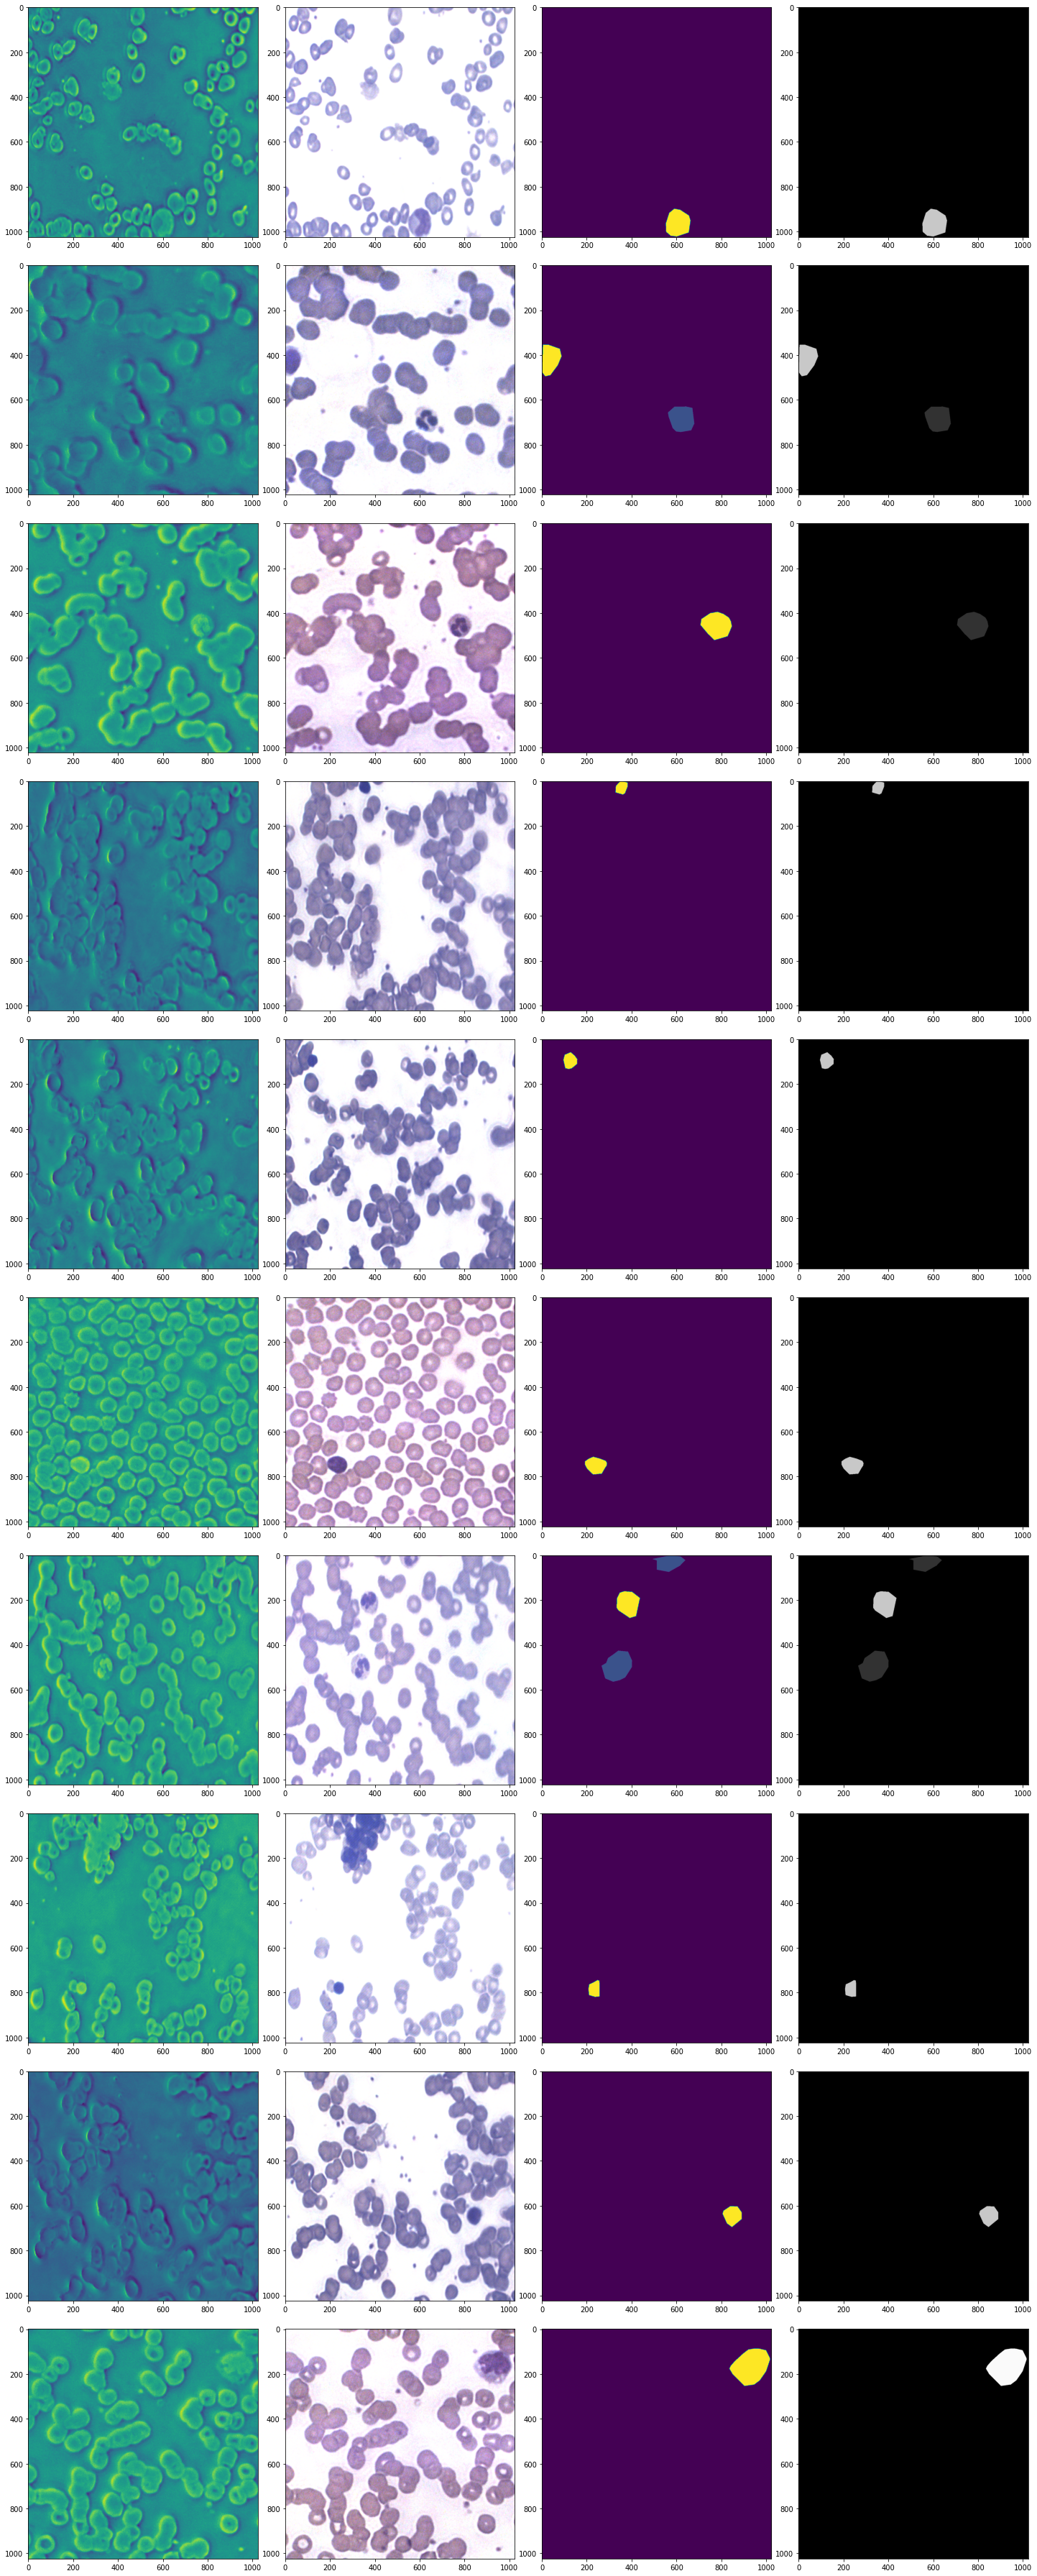

In [4]:
# fig = plt.figure(tight_layout = True)
num = 10
indicies = random.sample(range(len(slim_fns)), num)
rows, cols, size = num, 4, 5
fig = plt.figure(tight_layout=True,figsize=(size*cols, size*rows))
ax = fig.subplots(rows,cols)
for i in range(num):
    img_index = indicies[i]
    slim_file = slim_dir + '/{}'.format(slim_fns[img_index])
    bf_file = bf_dir + '/{}'.format(bf_fns[img_index])
    label_file = label_dir + '/{}'.format(label_fns[img_index])
    label_rgb_file = label_rgb_dir + '/{}'.format(label_rgb_fns[img_index])
    slim = io.imread(slim_file); print(slim.shape, slim.max(), slim.min())
    bf = io.imread(bf_file); print(bf.shape, bf.max(), bf.min())
    label = io.imread(label_file); print(label.shape, label.max(), label.min())
    label_rgb = io.imread(label_rgb_file); print(label_rgb.shape, label.max(), label_rgb.min())
    ax[i,0].imshow(slim)
    ax[i,1].imshow(bf)
    ax[i,2].imshow(label)
    ax[i,3].imshow(label_rgb*50)
    print(img_index)
    print(slim_file)
    print(bf_file)
    print(label_file)
    print(label_rgb_file)

0 140
(1024, 1024, 3) 255 65
(1024, 1024) 4.0 0.0
[0. 1. 4.]
Difference: 96.00
4
1 140
(1024, 1024, 3) 255 65
(1024, 1024) 4.0 0.0
[0. 1. 4.]
Difference: 96.00
4


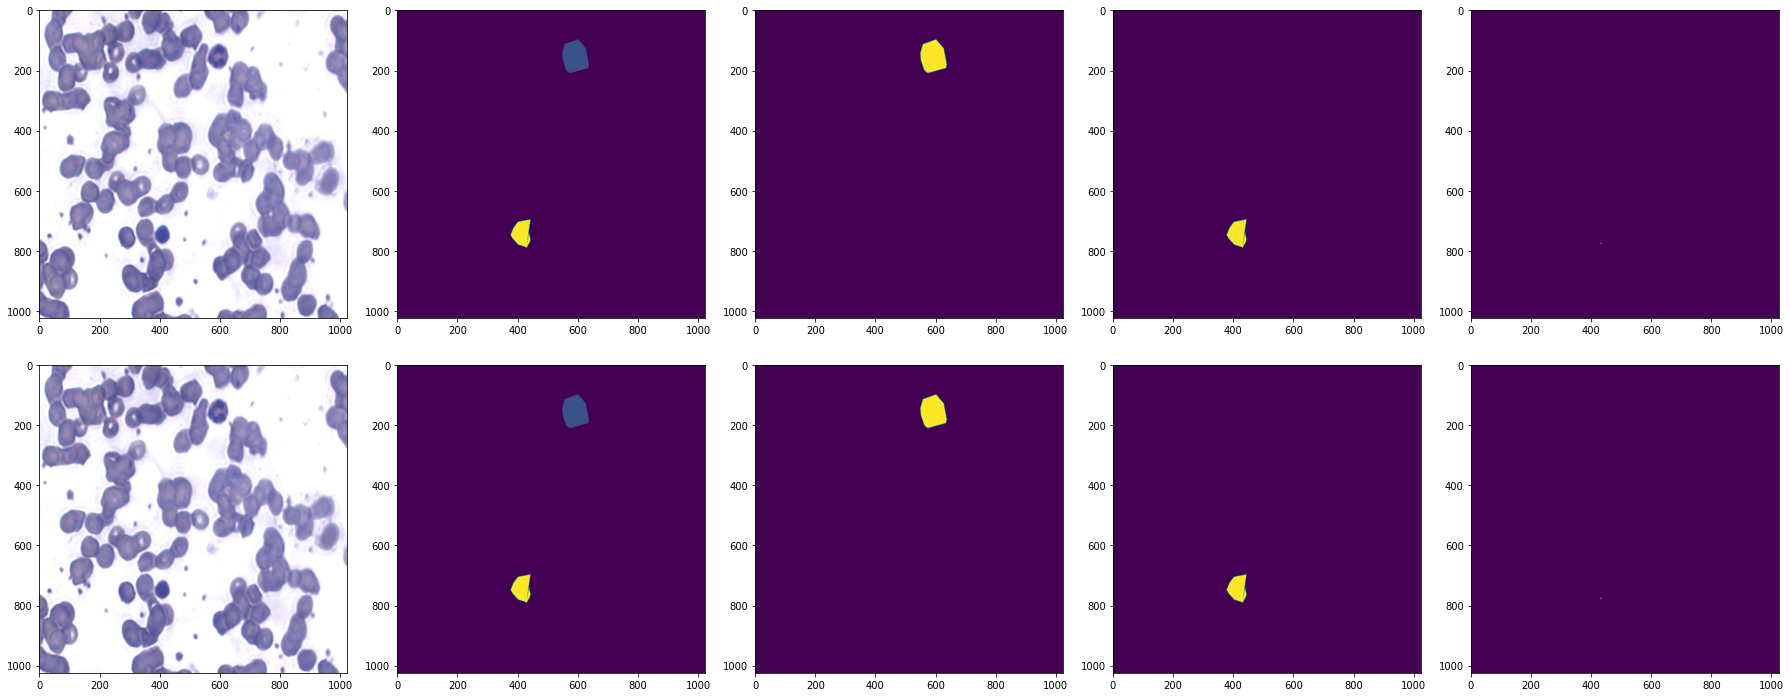

In [5]:
''' Testing the examples for Mask RCNN/YOLO/EfficientNet-D
'''
import scipy.ndimage as ndimage
random.seed(0)
num = 2
indices = random.sample(range(len(slim_fns)), num)
# img_index = indices[5]
rows, cols, size = num, 5, 5
fig = plt.figure(tight_layout=True,figsize=(size*cols, size*rows))
ax = fig.subplots(rows,cols)

for index in range(len(indices)):
#     img_index = indices[index]
    img_index = 140
    print(index, img_index)
    bf_file = bf_dir + '/{}'.format(bf_fns[img_index])
    label_file = label_dir + '/{}'.format(label_fns[img_index])
    bf = io.imread(bf_file); print(bf.shape, bf.max(), bf.min())
    label = io.imread(label_file); print(label.shape, label.max(), label.min())
    ax[index, 0].imshow(bf); ax[index, 1].imshow(label)
    # segment map into cell individuals
    cls_vals = np.unique(label)

    def find_connected_neighbors(xc, yc, p_set):
        find_points = []
        for i in range(-1,2):
            for j in range(-1,2):
                if (xc+i, yc+j) in p_set and not (i==0 and j ==0):
                    find_points.append((xc+i, yc+j))
        return find_points

    print(cls_vals)
    mask_list = []
    for cls_val in cls_vals:
        if cls_val == 0:
            continue
        # cls_val = cls_vals[1]
        map_layer = label == cls_val
        mshp = map_layer.shape
        outter = np.zeros((mshp[0]+2,mshp[1]+2))
        outter[1:-1,1:-1] = map_layer
        masks = np.zeros(mshp+(9,))
        for i in range(-1,2):
            for j in range(-1,2):
                masks[:,:,(i+1)*3+(j+1)]= outter[i+1:i+mshp[0]+1,j+1:j+mshp[1]+1]
        edge_mask = np.logical_and(np.sum(masks, axis = 2) < 9, np.sum(masks, axis = 2) >0)*map_layer
        fill_mask = ndimage.morphology.binary_fill_holes(edge_mask)

        # generate mask for each cell individuals
        xs, ys = np.where(edge_mask)
        point_set = set()
        for i in range(len(xs)):
            point_set.add((xs[i], ys[i]))

        obj_list = []
        cur_obj = set()
        obj_list.append(cur_obj)
        xc, yc = point_set.pop()
        to_check_q = []
        to_check_q.append((xc, yc))
        while point_set or to_check_q:
            while to_check_q:
                xc, yc = to_check_q.pop()
                cur_obj.add((xc, yc))
                neighbors = find_connected_neighbors(xc, yc, point_set)
                if len(neighbors) > 0:
                    to_check_q = to_check_q + neighbors
                    point_set = point_set - set(neighbors)
            if point_set:
                cur_obj=set()
                obj_list.append(cur_obj)
                xc, yc = point_set.pop()
                to_check_q = []
                to_check_q.append((xc,yc))

        for i in range(len(obj_list)):
            mask = np.zeros(mshp)
            for xy_tuple in list(obj_list[i]):
                mask[xy_tuple] = 1
            mask = ndimage.morphology.binary_fill_holes(mask)
            mask_list.append(mask)  # add to the mask list

    # check the correctness of the segmentation
    rec_map = np.zeros(mshp)
    for i in range(len(mask_list)):
        rec_map += label * mask_list[i]
    print('Difference: {:.2f}'.format(np.sum(np.abs(rec_map - label))))

    print(len(mask_list))
    ax[index, 2].imshow(mask_list[0]*label)
    if len(mask_list) > 1:
        ax[index, 3].imshow(mask_list[1]*label)
    if len(mask_list) > 2:
        ax[index, 4].imshow(mask_list[2]*label)

# save the object information for each image
rcnn_mask_dir = '/home/sh38/wb_cells/datasets/wbc_1024x1024'

In [6]:
''' Prepare the dataset for Mask RCNN/YOLO/EfficientNet-D
    SLIM phase images
'''
import shutil
import scipy.ndimage as ndimage
random.seed(0)
num = 20

def generate_folder(folder):
    if not os.path.exists(folder):
        os.system('mkdir -p {}'.format(folder))

# indices = random.sample(range(len(slim_fns)), num)
# img_index = indices[5]
# rows, cols, size = num, 5, 5
# fig = plt.figure(tight_layout=True,figsize=(size*cols, size*rows))
# ax = fig.subplots(rows,cols)
# save the object information for each image
rcnn_dir = '/home/sh38/wb_cells/datasets/wbc_1024x1024/rcnn'
box_dir = '/home/sh38/wb_cells/datasets/wbc_1024x1024/boxes'
generate_folder(box_dir)
# image_dir = bf_dir
# image_fns = bf_fns
image_dir = slim_dir
image_fns = slim_fns
for img_index in [140]:
# for img_index in range(len(slim_fns)):
    image_file = image_dir + '/{}'.format(image_fns[img_index])
    label_file = label_dir + '/{}'.format(label_fns[img_index])
    img = io.imread(image_file)
    label = io.imread(label_file)
    # ax[index, 0].imshow(bf); ax[index, 1].imshow(label)
    # segment map into cell individuals
    cls_vals = np.unique(label)

    def find_connected_neighbors(xc, yc, p_set):
        find_points = []
        for i in range(-1,2):
            for j in range(-1,2):
                if (xc+i, yc+j) in p_set and not (i==0 and j ==0):
                    find_points.append((xc+i, yc+j))
        return find_points

    # print(cls_vals)
    mask_list = []
    for cls_val in cls_vals:
        if cls_val == 0:
            continue
        # cls_val = cls_vals[1]
        map_layer = label == cls_val
        mshp = map_layer.shape
        outter = np.zeros((mshp[0]+2,mshp[1]+2))
        outter[1:-1,1:-1] = map_layer
        masks = np.zeros(mshp+(9,))
        for i in range(-1,2):
            for j in range(-1,2):
                masks[:,:,(i+1)*3+(j+1)]= outter[i+1:i+mshp[0]+1,j+1:j+mshp[1]+1]
        edge_mask = np.logical_and(np.sum(masks, axis = 2) < 9, np.sum(masks, axis = 2) >0)*map_layer
        fill_mask = ndimage.morphology.binary_fill_holes(edge_mask)

        # generate mask for each cell individuals
        xs, ys = np.where(edge_mask)
        point_set = set()
        for i in range(len(xs)):
            point_set.add((xs[i], ys[i]))

        obj_list = []
        cur_obj = set()
        obj_list.append(cur_obj)
        xc, yc = point_set.pop()
        to_check_q = []
        to_check_q.append((xc, yc))
        while point_set or to_check_q:
            while to_check_q:
                xc, yc = to_check_q.pop()
                cur_obj.add((xc, yc))
                neighbors = find_connected_neighbors(xc, yc, point_set)
                if len(neighbors) > 0:
                    to_check_q = to_check_q + neighbors
                    point_set = point_set - set(neighbors)
            if point_set:
                cur_obj=set()
                obj_list.append(cur_obj)
                xc, yc = point_set.pop()
                to_check_q = []
                to_check_q.append((xc,yc))

        for i in range(len(obj_list)):
            mask = np.zeros(mshp)
            for xy_tuple in list(obj_list[i]):
                mask[xy_tuple] = 1
            mask = ndimage.morphology.binary_fill_holes(mask)
            mask_list.append(mask)  # add to the mask list

    # check the correctness of the segmentation
    rec_map = np.zeros(mshp)
    for i in range(len(mask_list)):
        rec_map += label * mask_list[i]
    
    abs_dif = np.sum(np.abs(rec_map - label))
    if abs_dif >= 0:
        # save image
        rcnn_img_dir = rcnn_dir + '/{:04d}'.format(img_index) + '/images'
        generate_folder(rcnn_img_dir)
        shutil.copyfile(image_file, rcnn_img_dir + '/{:04d}.png'.format(img_index))
        # save gt_maps
        rcnn_map_dir = rcnn_dir + '/{:04d}'.format(img_index) + '/maps'
        generate_folder(rcnn_map_dir)
        shutil.copyfile(label_file, rcnn_map_dir + '/{:04d}.tif'.format(img_index))
        # save masks
        rcnn_mask_dir = rcnn_dir + '/{:04d}'.format(img_index) + '/masks'
        generate_folder(rcnn_mask_dir)
        for ii, mask in enumerate(mask_list):
            io.imsave(rcnn_mask_dir + '/mask_{:02d}.png'.format(ii), np.uint8(mask*label))
        # save gt_maps
        # bounding boxes: box_dir = '/home/sh38/wb_cells/datasets/wbc_1024x1024/boxes'
        box_file = box_dir + '/{:04d}.txt'.format(img_index)
        with open(box_file, 'w+') as f:
            for mask in mask_list[:-2]:
                mxs, mys = np.where(mask)
                tlx, tly = min(mxs), min(mys)
                drx, dry = max(mxs), max(mys)
                f.write('{},{},{},{}\n'.format(tlx, tly, drx, dry))
    elif abs_dif > 0 :
        print(img_index)
        print(cls_vals)
        print(img.shape, img.max(), img.min())
        print(label.shape, label.max(), label.min())
        print('Difference: {:.2f}'.format(np.sum(np.abs(rec_map - label))))

#     if img_index % 100 == 0: 
#         print(img_index)
#         print(cls_vals)
#         print(img.shape, img.max(), img.min())
#         print(label.shape, label.max(), label.min())
#         print('Difference: {:.2f}'.format(np.sum(np.abs(rec_map - label))))

/home/sh38/anaconda3/envs/proGAN_tf/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: /home/sh38/wb_cells/datasets/wbc_1024x1024/rcnn/0140/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/proGAN_tf/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: /home/sh38/wb_cells/datasets/wbc_1024x1024/rcnn/0140/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/proGAN_tf/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: /home/sh38/wb_cells/datasets/wbc_1024x1024/rcnn/0140/masks/mask_02.png is a low contrast image
/home/sh38/anaconda3/envs/proGAN_tf/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: /home/sh38/wb_cells/datasets/wbc_1024x1024/rcnn/0140/masks/mask_03.png is a low contrast image


In [7]:
''' Prepare the dataset for Mask RCNN/YOLO/EfficientNet-D
    White brightfield images
'''
import shutil
import scipy.ndimage as ndimage
random.seed(0)
num = 20

def generate_folder(folder):
    if not os.path.exists(folder):
        os.system('mkdir -p {}'.format(folder))

# indices = random.sample(range(len(slim_fns)), num)
# img_index = indices[5]
# rows, cols, size = num, 5, 5
# fig = plt.figure(tight_layout=True,figsize=(size*cols, size*rows))
# ax = fig.subplots(rows,cols)
# save the object information for each image
rcnn_dir = '/home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn'
box_dir = '/home/sh38/wb_cells/datasets/wbc2_1024x1024/boxes'
generate_folder(box_dir)
image_dir = bf_dir
image_fns = bf_fns
# image_dir = slim_dir
# image_fns = slim_fns
# for img_index in [140]:
for img_index in range(len(slim_fns)):
    image_file = image_dir + '/{}'.format(image_fns[img_index])
    label_file = label_dir + '/{}'.format(label_fns[img_index])
    img = io.imread(image_file)
    label = io.imread(label_file)
    # ax[index, 0].imshow(bf); ax[index, 1].imshow(label)
    # segment map into cell individuals
    cls_vals = np.unique(label)

    def find_connected_neighbors(xc, yc, p_set):
        find_points = []
        for i in range(-1,2):
            for j in range(-1,2):
                if (xc+i, yc+j) in p_set and not (i==0 and j ==0):
                    find_points.append((xc+i, yc+j))
        return find_points

    # print(cls_vals)
    mask_list = []
    for cls_val in cls_vals:
        if cls_val == 0:
            continue
        # cls_val = cls_vals[1]
        map_layer = label == cls_val
        mshp = map_layer.shape
        outter = np.zeros((mshp[0]+2,mshp[1]+2))
        outter[1:-1,1:-1] = map_layer
        masks = np.zeros(mshp+(9,))
        for i in range(-1,2):
            for j in range(-1,2):
                masks[:,:,(i+1)*3+(j+1)]= outter[i+1:i+mshp[0]+1,j+1:j+mshp[1]+1]
        edge_mask = np.logical_and(np.sum(masks, axis = 2) < 9, np.sum(masks, axis = 2) >0)*map_layer
        fill_mask = ndimage.morphology.binary_fill_holes(edge_mask)

        # generate mask for each cell individuals
        xs, ys = np.where(edge_mask)
        point_set = set()
        for i in range(len(xs)):
            point_set.add((xs[i], ys[i]))

        obj_list = []
        cur_obj = set()
        obj_list.append(cur_obj)
        xc, yc = point_set.pop()
        to_check_q = []
        to_check_q.append((xc, yc))
        while point_set or to_check_q:
            while to_check_q:
                xc, yc = to_check_q.pop()
                cur_obj.add((xc, yc))
                neighbors = find_connected_neighbors(xc, yc, point_set)
                if len(neighbors) > 0:
                    to_check_q = to_check_q + neighbors
                    point_set = point_set - set(neighbors)
            if point_set:
                cur_obj=set()
                obj_list.append(cur_obj)
                xc, yc = point_set.pop()
                to_check_q = []
                to_check_q.append((xc,yc))

        for i in range(len(obj_list)):
            mask = np.zeros(mshp)
            for xy_tuple in list(obj_list[i]):
                mask[xy_tuple] = 1
            mask = ndimage.morphology.binary_fill_holes(mask)
            mask_list.append(mask)  # add to the mask list

    # check the correctness of the segmentation
    rec_map = np.zeros(mshp)
    for i in range(len(mask_list)):
        rec_map += label * mask_list[i]
    
    abs_dif = np.sum(np.abs(rec_map - label))
    if abs_dif >= 0:
        # save image
        rcnn_img_dir = rcnn_dir + '/{:04d}'.format(img_index) + '/images'
        generate_folder(rcnn_img_dir)
        shutil.copyfile(image_file, rcnn_img_dir + '/{:04d}.png'.format(img_index))
        # save gt_maps
        rcnn_map_dir = rcnn_dir + '/{:04d}'.format(img_index) + '/maps'
        generate_folder(rcnn_map_dir)
        shutil.copyfile(label_file, rcnn_map_dir + '/{:04d}.tif'.format(img_index))
        # save masks
        rcnn_mask_dir = rcnn_dir + '/{:04d}'.format(img_index) + '/masks'
        generate_folder(rcnn_mask_dir)
        for ii, mask in enumerate(mask_list):
            if np.sum(mask) < 100:
                continue
            io.imsave(rcnn_mask_dir + '/mask_{:02d}.png'.format(ii), np.uint8(mask*label))
        # save gt_maps
        # bounding boxes: box_dir = '/home/sh38/wb_cells/datasets/wbc_1024x1024/boxes'
        box_file = box_dir + '/{:04d}.txt'.format(img_index)
        with open(box_file, 'w+') as f:
            for mask in mask_list[:-2]:
                mxs, mys = np.where(mask)
                tlx, tly = min(mxs), min(mys)
                drx, dry = max(mxs), max(mys)
                f.write('{},{},{},{}\n'.format(tlx, tly, drx, dry))
    elif abs_dif > 0 :
        print(img_index)
        print(cls_vals)
        print(img.shape, img.max(), img.min())
        print(label.shape, label.max(), label.min())
        print('Difference: {:.2f}'.format(np.sum(np.abs(rec_map - label))))

#     if img_index % 100 == 0: 
#         print(img_index)
#         print(cls_vals)
#         print(img.shape, img.max(), img.min())
#         print(label.shape, label.max(), label.min())
#         print('Difference: {:.2f}'.format(np.sum(np.abs(rec_map - label))))

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0000/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0001/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0001/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0001/masks/mask_02.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0002/masks/mask_00.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0022/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0023/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0023/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0023/masks/mask_02.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0023/masks/mask_03.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0042/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0042/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0042/masks/mask_02.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0043/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0043/masks/mask_01.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0069/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0070/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0070/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0070/masks/mask_02.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0070/masks/mask_03.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0098/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0099/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0099/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0099/masks/mask_02.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0100/masks/mask_00.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0120/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0120/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0121/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0122/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0122/masks/mask_01.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0149/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0150/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0150/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0151/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0151/masks/mask_01.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0175/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0176/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0176/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0177/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0177/masks/mask_01.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0201/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0202/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0203/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0204/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0205/masks/mask_00.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0233/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0234/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0235/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0235/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0235/masks/mask_02.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0258/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0259/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0260/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0260/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0260/masks/mask_02.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0289/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0290/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0291/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0291/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0292/masks/mask_00.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0325/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0326/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0327/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0328/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0328/masks/mask_01.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0364/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0364/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0365/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0366/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0366/masks/mask_01.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0393/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0394/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0395/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0395/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0396/masks/mask_00.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0426/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0427/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0428/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0428/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0429/masks/mask_00.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0458/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0459/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0460/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0461/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0462/masks/mask_00.png is a low 

/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0495/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0496/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0496/masks/mask_01.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0497/masks/mask_00.png is a low contrast image
/home/sh38/anaconda3/envs/effdet_tf1.5/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: /home/sh38/wb_cells/datasets/wbc2_1024x1024/rcnn/0498/masks/mask_00.png is a low 

In [ ]:
''' prepare datasets for SLIM
'''
import shutil
def generate_folder(folder):
    if not os.path.exists(folder):
        os.system('mkdir -p {}'.format(folder))

output_dir = '../../../datasets/'
dataset = 'wbc_1024x1024'
dataset_folder = output_dir+dataset
generate_folder(dataset_folder)
image_folder = dataset_folder + '/images'
map_folder = dataset_folder + '/seg_maps'
generate_folder(image_folder)
generate_folder(map_folder)

# for i in range(2):
for i in range(len(slim_fns)):
    shutil.copyfile(slim_dir + '/' + slim_fns[i], image_folder + '/' + '{:04d}.png'.format(i))
    os.system('cp -f {} {}'.format(label_dir + '/' + label_fns[i], map_folder + '/' + '{:04d}.tif'.format(i)))
    if i % 100 == 0:
        print('{} images copied!'.format(i))

In [6]:
''' prepare datasets Bright field
'''
import shutil
def generate_folder(folder):
    if not os.path.exists(folder):
        os.system('mkdir -p {}'.format(folder))

output_dir = '../../../datasets/'
dataset = 'wbc2_1024x1024'
dataset_folder = output_dir+dataset
generate_folder(dataset_folder)
image_folder = dataset_folder + '/images'
map_folder = dataset_folder + '/seg_maps'
generate_folder(image_folder)
generate_folder(map_folder)

# for i in range(2):
for i in range(len(bf_fns)):
    shutil.copyfile(bf_dir + '/' + bf_fns[i], image_folder + '/' + '{:04d}.png'.format(i))
    os.system('cp -f {} {}'.format(label_dir + '/' + label_fns[i], map_folder + '/' + '{:04d}.tif'.format(i)))
    if i % 100 == 0:
        print('{} images copied!'.format(i))

0 images copied!
100 images copied!
200 images copied!
300 images copied!
400 images copied!
500 images copied!


In [ ]:
''' prepare datasets for White brightfield
'''
import shutil
def generate_folder(folder):
    if not os.path.exists(folder):
        os.system('mkdir -p {}'.format(folder))
obf = '/home/sh38/wb_cells/data_from_MK/WBC_sem_seg/WBC_Brightfield'
obf_fns =
output_dir = '../../../datasets/'
dataset = 'wbc3_1024x1024'
dataset_folder = output_dir+dataset
generate_folder(dataset_folder)
image_folder = dataset_folder + '/images'
map_folder = dataset_folder + '/seg_maps'
generate_folder(image_folder)
generate_folder(map_folder)

# for i in range(2):
for i in range(len(slim_fns)):
    shutil.copyfile(slim_dir + '/' + slim_fns[i], image_folder + '/' + '{:04d}.png'.format(i))
    os.system('cp -f {} {}'.format(label_dir + '/' + label_fns[i], map_folder + '/' + '{:04d}.tif'.format(i)))
    if i % 100 == 0:
        print('{} images copied!'.format(i))

In [75]:
''' Split the test/val/test
'''
random.seed(0) # set the random seed
fns = os.listdir(image_folder); print('total: {}'.format(len(fns)))
test_set = random.sample(fns, 100); print('test: {}'.format(len(test_set)))
rest_set = [fn for fn in fns if fn not in test_set]; print('after test: {}'.format(len(rest_set)))
val_set = random.sample(rest_set, 100); print('valid: {}'.format(len(val_set)))
train_set = [fn for fn in fns if fn not in test_set and fn not in val_set]; print('train: {}'.format(len(train_set)))

# save test file
test_file = dataset_folder + '/test_list.txt'
with open(test_file, 'w+') as f:
    for fn in test_set:
        f.write('{}\n'.format(fn.split('.')[0]))
print(test_file + ' saved!')

# save valid file
valid_file = dataset_folder + '/valid_list.txt'
with open(valid_file, 'w+') as f:
    for fn in val_set:
        f.write('{}\n'.format(fn.split('.')[0]))
print(valid_file + ' saved!')

# save train file
train_file = dataset_folder + '/train_list.txt'
with open(train_file, 'w+') as f:
    for fn in train_set:
        f.write('{}\n'.format(fn.split('.')[0]))
print(train_file + ' saved!')

total: 504
test: 100
after test: 404
valid: 100
train: 304
../../../datasets/wbc_1024x1024/test_list.txt saved!
../../../datasets/wbc_1024x1024/valid_list.txt saved!
../../../datasets/wbc_1024x1024/train_list.txt saved!
